# Post-processing tools

In this notebook we develop and debug the functions we use for post-processing our data.

## 0. Import  

In [2]:
import numpy as np

from sklearn.neighbors import KernelDensity

from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.optimize import brentq

In [3]:
# For plotting

import corner

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Custom mplstyle file we use
plt.style.use('/home/hosilva/tools/mplstyle/timesnromanstyle.mplstyle')

%matplotlib inline
%config InlineBackend.figure_format='retina'

## 1. Loading posterior samples

We will use the posterior samples of two PE runs to implement and validate our code.

In [4]:
data_GW200129 = np.genfromtxt("/home/hosilva/parspec/pe/GW200129/p4_l_df0_dtau0_CS_220124/cbcBayes/posterior_samples.dat",  
                              names=True, dtype=None, max_rows=30000)

data_GW150914 = np.genfromtxt("/home/hosilva/parspec/pe/GW150914/parspec_runs/p4_l_df0_dtau0_CS_220203_1052/cbcBayes/posterior_samples.dat", 
                              names=True, dtype=None, max_rows=30000)

**Sanity check**: the samples for `domega220` and `dtau220` should be same always and be identical between events.

In [5]:
(data_GW200129['domega220'] - data_GW150914['domega220']) == np.zeros(len(data_GW150914['domega220']))

array([ True,  True,  True, ...,  True,  True,  True])

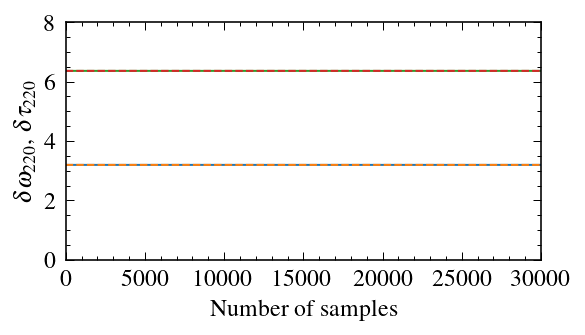

In [6]:
fig, ax = plt.subplots(figsize=(4, 2))

ax.plot(data_GW200129['domega220'])
ax.plot(data_GW150914['domega220'], '--')

ax.plot(data_GW200129['dtau220'])
ax.plot(data_GW150914['dtau220'], '--')

ax.set_ylim(0, 8)
ax.set_xlim(0, 30000)

ax.set_xlabel('Number of samples')
ax.set_ylabel(r'$\delta\omega_{220}$, $\delta\tau_{220}$');

In [7]:
def read_relevant_columns(samples):
    """
    Takes a 'posterior_samples.dat' file (found in cbcBayes of each PE run) and 
    return the columns we are mostly interested in.
    """
    alpha_ngr = samples['alphangr']
    m1_source = samples['m2_source']
    m2_source = samples['m2_source']
    mf_source = samples['mf_source_evol']
    z = samples['redshift']
    
    return alpha_ngr, m1_source, m2_source, mf_source, z

def get_dimensionless_coupling_posterior(smp_l, smp_mass, p=4):
    """
    Combines the PE samples of l (smp_l), one of the masses (smp_mass) for 
    a given exponent p as:
    
    gamma = (l / smp_mass)^{p}
    
    """
    # Convert mass from solar masses to km
    Msun_to_km = 1.476

    smp_mass_geo = smp_mass * Msun_to_km
        
    return (smp_l / smp_mass_geo)**p

def get_threshold(smp_mass, thr_coef=1/2.):
    """
    Given the PE samples on a mass (smp_mass) we calculate the associated median,
    convert to km and multiply by a value thr_coed (between 0 and 1). This sets 
    the length scale below which our posterior in the coupling l should be below
    if we want to claim any constraint. The default values is 0.5, which was used 
    in other papers.
    """
    # Convert mass from solar masses to km
    Msun_to_km = 1.476
    
    smp_mass_geo = np.median(smp_mass) * Msun_to_km
    
    return thr_coef * m_in_km

In [8]:
GW200129_smp_l, GW200129_smp_m1s, GW200129_smp_m2s, GW200129_smp_mfs, GW200129_smp_z = read_relevant_columns(data_GW200129)
GW150914_smp_l, GW150914_smp_m1s, GW150914_smp_m2s, GW150914_smp_mfs, GW150914_smp_z = read_relevant_columns(data_GW150914)

## 2. Obtaining Kernel Density Estimators

We follow 

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

In [9]:
# First we make super set of samples {x_i} U -{x_i}
tmp_smp_l_full = np.concatenate((GW200129_smp_l, -GW200129_smp_l))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


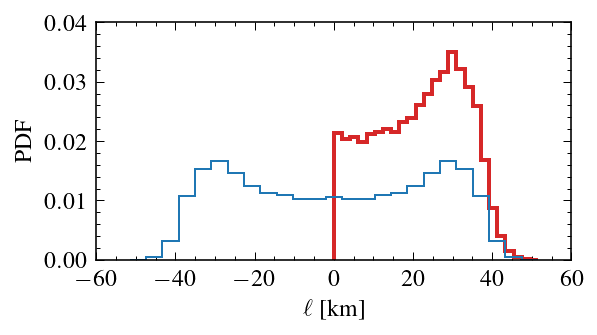

In [10]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.hist(GW200129_smp_l, density=True, histtype='step', bins=25, color='C3', lw=2);
ax.hist(tmp_smp_l_full, density=True, histtype='step', bins=25,);

ax.set_xlim(-60, 60);
ax.set_ylim(0, 0.04);

ax.set_ylabel('PDF');
ax.set_xlabel(r'$\ell$ [km]');

ax.legend()

In [11]:
np.arange(- 10, 10 + 1, 1)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [12]:
def get_kde_l(smp_l, l_min = 0, l_max = 60, vis=False):
    """
    Get the samples in the dimensionful coupling constant l
    and output a Kernel Denisty Estimator. 
    
    In general, we find that the sharp boundary at l = 0
    causes problems in generating a KDE that reflects the 
    true distribution. To avoid this we use the "mirror-around-zero" 
    approach of 2104.11189.
    
    We follow: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
    """
    
    from scipy.stats import norm
    from sklearn.neighbors import KernelDensity
    from scipy.interpolate import InterpolatedUnivariateSpline as ius
    
    # Mirror around l = 0
    smp_l_full = np.concatenate((smp_l, -smp_l))
    
    # Create l values
    dl = 1
    l = np.arange(- l_max, l_max + dl, dl)    
    density = sum(norm(li).pdf(l) for li in smp_l_full)
    
    # Instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=2.0, kernel='gaussian')
    kde.fit(smp_l_full[:, None])

    # Score_samples returns the log of the probability density
    logprob = kde.score_samples(l[:, None])
    prob = np.exp(logprob)
    
    # Now we take only the l >= 0 values and the associated KDE values, making a interpolating spline
    # normalize then normalize a final time.

    l_mid = int((len(l) - 1) / 2)
    l_pos = l[l_mid:]
    pdf_pos = prob[l_mid:]
    
    pdf_l_interp = ius(l_pos, pdf_pos)
    
    if vis:
        # Compute the KDE using the same process, but without the mirroring
        # for illustrative purposes
        density_illus = sum(norm(li).pdf(l_pos) for li in smp_l)
        kde_illus = KernelDensity(bandwidth=2.0, kernel='gaussian')
        kde_illus.fit(smp_l[:, None])
        prob_illus = np.exp(kde_illus.score_samples(l_pos[:, None]))
        
        fig, ax = plt.subplots(figsize=(4, 2))
        ax.plot(l_pos, pdf_l_interp(l_pos) / pdf_l_interp.integral(l_min, l_max), 'k-', lw=1, label='KDE')
        ax.plot(l_pos, prob_illus, 'C1:', lw=1, label='KDE (no mirror)')
        ax.hist(smp_l, density=True, histtype='step', color='C3', lw=1)
        ax.set_xlim(l_min, l_max)
        ax.set_xlabel(r'$\ell$ [km]')
        ax.set_ylabel('PDF')
        ax.legend(loc='best', fontsize=8)
            
    return l_pos, pdf_l_interp(l_pos) / pdf_l_interp.integral(l_min, l_max)

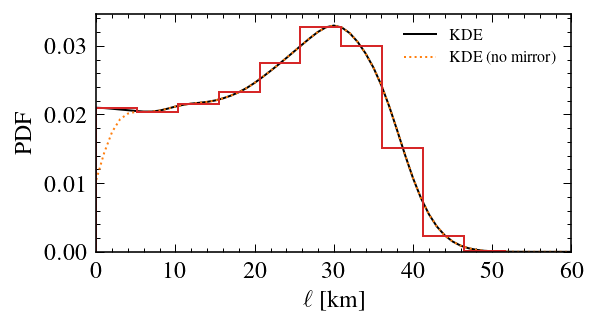

In [13]:
x_tmp, y_tmp = get_kde_l(GW200129_smp_l, vis=True)

In [14]:
def get_cdf(x, y, vis=False):
    """
    Return an interpolating function for the cumulative density function (CDF)
    """
    
    from scipy.interpolate import InterpolatedUnivariateSpline as ius
    
    yx_interp = ius(x, y)
    
    cdf = [yx_interp.integral(0, x_max) for x_max in x]
    
    if vis:
        fig, ax = plt.subplots(figsize=(4, 2))

        ax.plot(x, cdf)
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(0, 1.1)
        ax.set_xlabel(r'$\ell$ [km]')
        ax.set_ylabel('CDF')
    
    return x, cdf

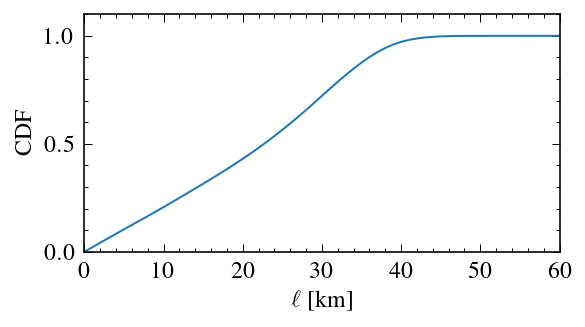

In [15]:
_, cdf_tmp = get_cdf(x_tmp, y_tmp, vis=True)

In [16]:
def get_percentage(l, cdf, pct=0.9, vis=False):
    """
    Given values of l and the corresponding CDF, 
    locate the value of l for which CDF = pct.
    
    Default value is pct=0.9
    """
    
    from scipy.interpolate import InterpolatedUnivariateSpline as ius
    from scipy.optimize import brentq
    
    cdf_interp = ius(l, cdf)
    
    def root_finder(x):
        return cdf_interp(x) - pct

    l_at_pct = brentq(root_finder, min(l), max(l))
    
    if vis:
        fig, ax = plt.subplots(figsize=(4, 2))

        ax.plot(l, cdf)
        ax.axhline(pct, c='k', ls='-')
        ax.axvline(l_at_pct, c='k', ls='-')
        ax.set_xlim(min(l), max(l))
        ax.set_ylim(0, 1.1)
        ax.set_xlabel(r'$\ell$ [km]')
        ax.set_ylabel('CDF')        
    
    return l_at_pct

35.93177157834739


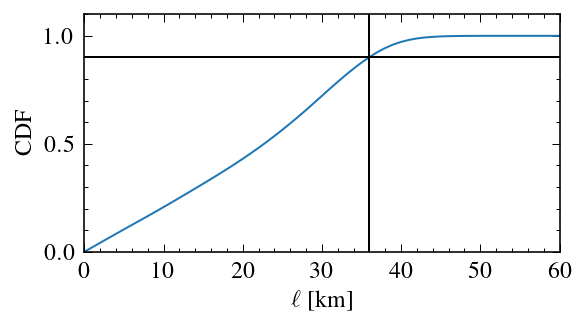

In [17]:
print(get_percentage(x_tmp, cdf_tmp, vis=True))

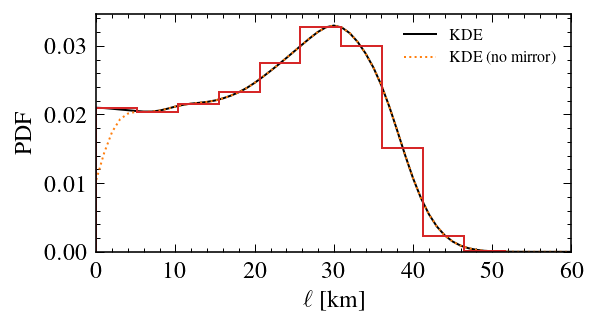

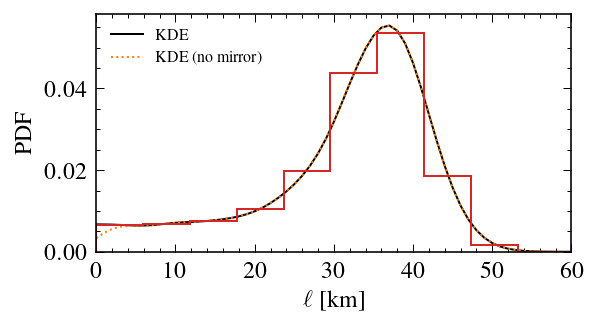

In [18]:
x1_tmp, y1_tmp = get_kde_l(GW200129_smp_l, vis=True)
x2_tmp, y2_tmp = get_kde_l(GW150914_smp_l, vis=True)

In [19]:
def do_posterior_combine(x1, y1, prior_limits1, 
                         x2, y2, prior_limits2, 
                         vis=False):

    """
    Computes the joint posterior
    """
    
    # Create the interpolants
    from scipy.interpolate import InterpolatedUnivariateSpline as ius

    yx1_kde = ius(x1, y1)
    yx2_kde = ius(x2, y2)
    
    # Now we multiply them:
    x12_vals = np.linspace(0, max(x1), num=len(x1))
    
    y12_vals = [yx1_kde(x) * yx2_kde(x) for x in x12_vals]
    
    yx12_combined = ius(x12_vals, y12_vals)
    yx12_normalisation = yx12_combined.integral(0, max(x1))
    
    if vis:
        fig, ax = plt.subplots(figsize=(4, 2))

        ax.plot(x1, y1, 'C0-', label='Posterior 1')
        ax.plot(x2, y2, 'C1--', label='Posterior 2')
        ax.plot(x1, yx12_combined(np.array(x1)) / yx12_normalisation, 'C2:', label='Combined posterior')

        ax.set_xlim(min(x1), max(x1))
        
        ax.set_xlabel(r'$\ell$ [km]')
        ax.set_ylabel('PDF')
        
        ax.legend(loc='best', fontsize=8)
    
    return x12_vals, yx12_combined(np.array(x1)) / yx12_normalisation

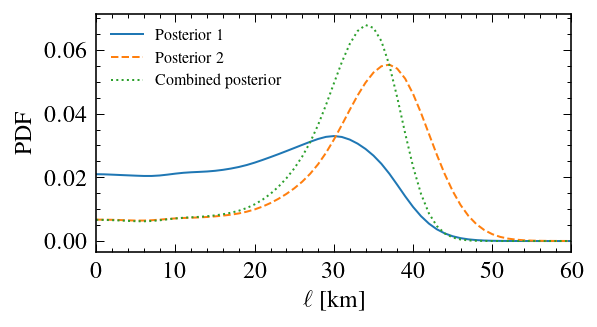

In [20]:
_, _ = do_posterior_combine(x1_tmp, y1_tmp, [0, 60], 
                            x2_tmp, y2_tmp, [0, 60],
                            vis=True)                            

In [25]:
def get_threshold(smp_mass, thr_coef=1/2.):
    # Convert mass from solar masses to km
    Msun_to_km = 1.476
    m_in_km = np.median(smp_mass) * Msun_to_km
    return thr_coef * m_in_km

def find_cdf_at_threshold(smp_mass, kde_x, kde_l, lmax=68):
    # Create an interpolating function for the posterior
    # given the input KDE
    pdf_l_tmp = ius(kde_x, kde_l)
    
    # Calculate CDF at sample values of l by integrating the posterior
    l_vals = np.arange(0, lmax + 1, 1)
    cdf_tmp = [pdf_l_tmp.integral(0, lmax) for lmax in l_vals]
    cdf_l_tmp = ius(l_vals, cdf_tmp)
    
    # Find where it is 90%
    def find_x90(x): return cdf_l_tmp(x) - 0.90
    def find_x68(x): return cdf_l_tmp(x) - 0.68
    x90 = brentq(find_x90, 0, max(l_vals))
    x68 = brentq(find_x68, 0, max(l_vals))
    print(x68, x90, get_threshold(smp_mass, 1/2.))
    
    # Set a number of epsilon and calculate the thresholds values
    epsilon_vals  = np.arange(0, 1.0 + 0.01, 0.01)
    m_thresholds  = np.array([get_threshold(smp_mass, eps) for eps in epsilon_vals]) # in km

    # Finally, calculate the cdf at the threshold values
    cdf_at_m_thresholds = np.array([cdf_l_tmp(m) for m in m_thresholds])
    
    return epsilon_vals, cdf_at_m_thresholds

In [28]:
eps_val, GW200129_m2 = find_cdf_at_threshold(GW200129_smp_m2s, x1_tmp, y1_tmp)
_, GW200129_mf = find_cdf_at_threshold(GW200129_smp_mfs, x1_tmp, y1_tmp)

28.719674313462654 35.931771578347394 21.38785240277963
28.719674313462654 35.931771578347394 43.81762914505016


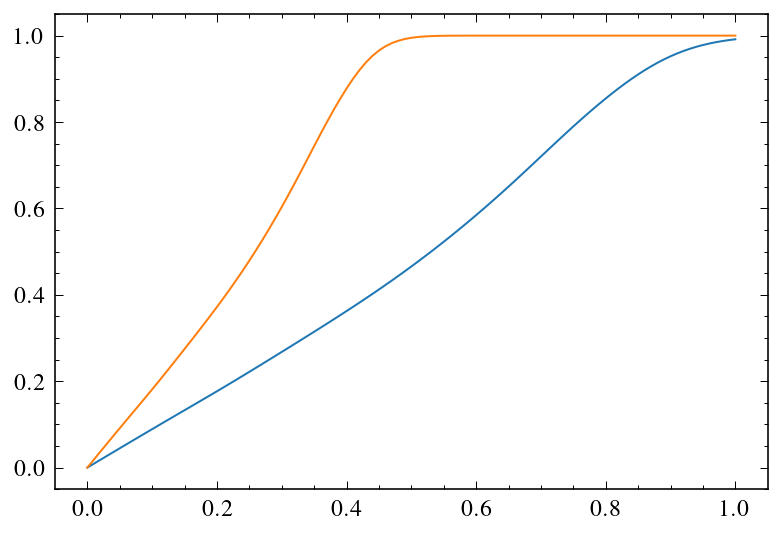

In [31]:
plt.plot(eps_val, GW200129_m2)
plt.plot(eps_val, GW200129_mf)